# Computer Vision 2023 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question is a more challenging classification experiment on a larger dataset. Answer the questions in separate Python notebooks.

## Question 1: A simple classifier, 20 marks

For this exercise, we provide demo code showing how to train a network on a small dataset called [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure.

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

**Q1.1 (1 point)**

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels.

**Q1.2 (2 points)**

Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   |      |
|0.1|          |
|0.01|         |
|0.001  |        |


**Q1.3 (3 points)**

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loass curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |      |     |
|0.1|          |    |
|0.01|         |    |
|0.001  |        |     |


**Q1.4 (2 points)**

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?


**Q1.5 (5 points)**

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |      ||
|Deeper|          ||
|Wider|         ||


**Q1.6 (2 points)**

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

**Q1.7 (5 points)**

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/cv_assignment3'

Mounted at /content/drive
/content/drive/My Drive/cv_assignment3


In [61]:
import numpy as np # This is for mathematical operations

# this is used in plotting
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset.
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets.
##Every TorchVision Dataset includes two arguments:
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

**NOTE**: For consistency with the original data set, we call our validation data "test_data". It is important to keep in mind though that we are using the data for model validation and not for testing the final, trained model (which requires data not used when training the model parameters).

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [63]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


### Answer 1.1

Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

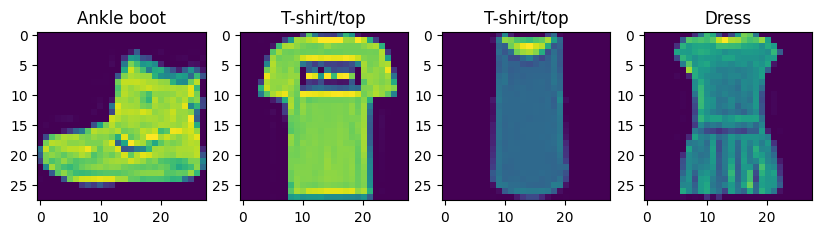

In [64]:
# Code cell for training image display
import matplotlib.pyplot as plt
import numpy as np
import torchvision
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

fig, plots = plt.subplots(1, 4, figsize=(10,10))
for i in range(4):
    plots[i].imshow(images[i][0,:,:])
    plots[i].set_title(f'{class_names[labels[i]]:5s}')

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [65]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [66]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [67]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [68]:
##Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
#Train and test the model
train_losses = []
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299013  [    0/60000]
loss: 2.280474  [ 6400/60000]
loss: 2.263964  [12800/60000]
loss: 2.257785  [19200/60000]
loss: 2.241146  [25600/60000]
loss: 2.215092  [32000/60000]
loss: 2.215814  [38400/60000]
loss: 2.182139  [44800/60000]
loss: 2.176809  [51200/60000]
loss: 2.148305  [57600/60000]
Test Error: 
 Accuracy: 55.0%, Avg loss: 2.139849 

Epoch 2
-------------------------------
loss: 2.155280  [    0/60000]
loss: 2.136686  [ 6400/60000]
loss: 2.080699  [12800/60000]
loss: 2.093132  [19200/60000]
loss: 2.045789  [25600/60000]
loss: 1.988069  [32000/60000]
loss: 2.002267  [38400/60000]
loss: 1.929251  [44800/60000]
loss: 1.935883  [51200/60000]
loss: 1.851535  [57600/60000]
Test Error: 
 Accuracy: 61.9%, Avg loss: 1.852097 

Epoch 3
-------------------------------
loss: 1.898523  [    0/60000]
loss: 1.854987  [ 6400/60000]
loss: 1.741155  [12800/60000]
loss: 1.772208  [19200/60000]
loss: 1.668049  [25600/60000]
loss: 1.627689  [32000/600

### Answer 1.2
Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:


|Lr|Accuracy|
|---|:---:|
|1   |   19.9   |
|0.1|    87.5      |
|0.01|   83.3      |
|0.001  |71.7     |

In [11]:
def plot_loss_curve(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

Epoch 1
-------------------------------
loss: 2.299908  [    0/60000]
loss: 2.313537  [ 6400/60000]
loss: 2.156015  [12800/60000]
loss: 2.096079  [19200/60000]
loss: 1.858348  [25600/60000]
loss: 2.304760  [32000/60000]
loss: 2.305774  [38400/60000]
loss: 2.288649  [44800/60000]
loss: 2.353192  [51200/60000]
loss: 2.330049  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.306015 

Epoch 2
-------------------------------
loss: 2.313041  [    0/60000]
loss: 2.306792  [ 6400/60000]
loss: 2.312775  [12800/60000]
loss: 2.304621  [19200/60000]
loss: 2.279665  [25600/60000]
loss: 2.304897  [32000/60000]
loss: 2.306009  [38400/60000]
loss: 1.506473  [44800/60000]
loss: 1.882722  [51200/60000]
loss: 1.714138  [57600/60000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.746574 

Epoch 3
-------------------------------
loss: 1.741465  [    0/60000]
loss: 1.689417  [ 6400/60000]
loss: 1.816089  [12800/60000]
loss: 1.782776  [19200/60000]
loss: 1.778214  [25600/60000]
loss: 1.783920  [32000/600

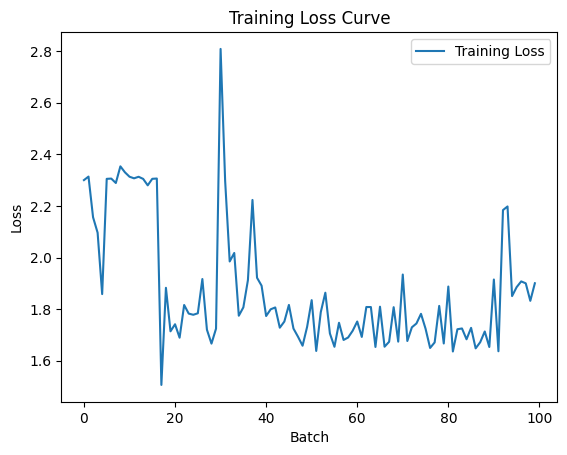

In [17]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
#Train and test the model
train_losses = []
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")
plot_loss_curve(train_losses)

Epoch 1
-------------------------------
loss: 2.295530  [    0/60000]
loss: 0.892366  [ 6400/60000]
loss: 0.571334  [12800/60000]
loss: 0.710809  [19200/60000]
loss: 0.592881  [25600/60000]
loss: 0.507794  [32000/60000]
loss: 0.544822  [38400/60000]
loss: 0.600603  [44800/60000]
loss: 0.608585  [51200/60000]
loss: 0.451764  [57600/60000]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.539894 

Epoch 2
-------------------------------
loss: 0.405395  [    0/60000]
loss: 0.427792  [ 6400/60000]
loss: 0.369343  [12800/60000]
loss: 0.435721  [19200/60000]
loss: 0.394857  [25600/60000]
loss: 0.436365  [32000/60000]
loss: 0.421796  [38400/60000]
loss: 0.508316  [44800/60000]
loss: 0.510842  [51200/60000]
loss: 0.426153  [57600/60000]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.474973 

Epoch 3
-------------------------------
loss: 0.333812  [    0/60000]
loss: 0.347984  [ 6400/60000]
loss: 0.302415  [12800/60000]
loss: 0.362204  [19200/60000]
loss: 0.340230  [25600/60000]
loss: 0.403630  [32000/600

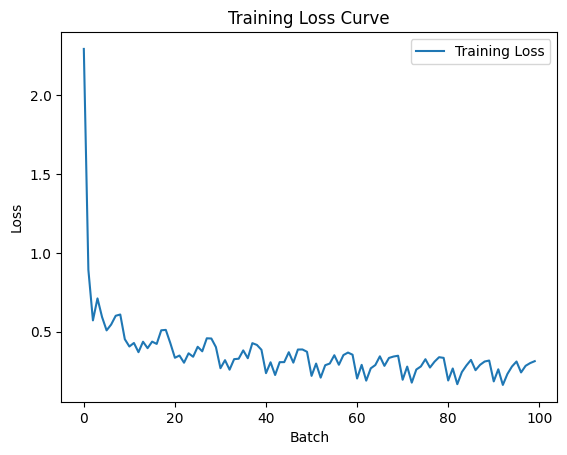

In [21]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
#Train and test the model
train_losses = []
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")
plot_loss_curve(train_losses)

Epoch 1
-------------------------------
loss: 2.308668  [    0/60000]
loss: 2.179949  [ 6400/60000]
loss: 1.839021  [12800/60000]
loss: 1.546625  [19200/60000]
loss: 1.176367  [25600/60000]
loss: 1.066043  [32000/60000]
loss: 1.021106  [38400/60000]
loss: 0.880285  [44800/60000]
loss: 0.886205  [51200/60000]
loss: 0.806599  [57600/60000]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.802482 

Epoch 2
-------------------------------
loss: 0.812387  [    0/60000]
loss: 0.856551  [ 6400/60000]
loss: 0.597444  [12800/60000]
loss: 0.780863  [19200/60000]
loss: 0.670138  [25600/60000]
loss: 0.639221  [32000/60000]
loss: 0.712494  [38400/60000]
loss: 0.683305  [44800/60000]
loss: 0.715752  [51200/60000]
loss: 0.632830  [57600/60000]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.636848 

Epoch 3
-------------------------------
loss: 0.571635  [    0/60000]
loss: 0.665102  [ 6400/60000]
loss: 0.443730  [12800/60000]
loss: 0.660885  [19200/60000]
loss: 0.574954  [25600/60000]
loss: 0.554969  [32000/600

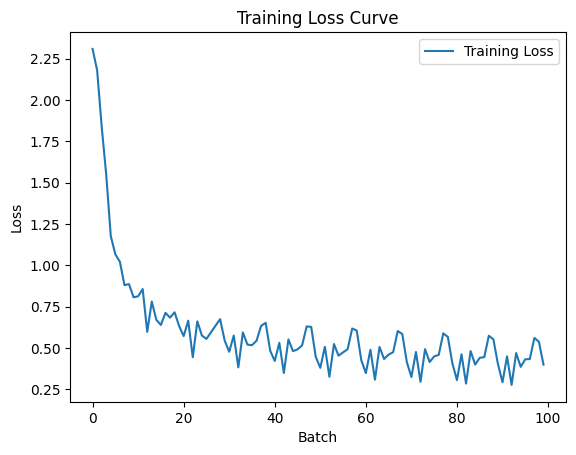

In [24]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
#Train and test the model
train_losses = []
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")
plot_loss_curve(train_losses)

Epoch 1
-------------------------------
loss: 2.297098  [    0/60000]
loss: 2.289997  [ 6400/60000]
loss: 2.266395  [12800/60000]
loss: 2.271855  [19200/60000]
loss: 2.259746  [25600/60000]
loss: 2.223984  [32000/60000]
loss: 2.241616  [38400/60000]
loss: 2.205846  [44800/60000]
loss: 2.194686  [51200/60000]
loss: 2.187334  [57600/60000]
Test Error: 
 Accuracy: 43.0%, Avg loss: 2.169706 

Epoch 2
-------------------------------
loss: 2.168962  [    0/60000]
loss: 2.163792  [ 6400/60000]
loss: 2.104743  [12800/60000]
loss: 2.135828  [19200/60000]
loss: 2.088824  [25600/60000]
loss: 2.023081  [32000/60000]
loss: 2.062882  [38400/60000]
loss: 1.982904  [44800/60000]
loss: 1.985841  [51200/60000]
loss: 1.940632  [57600/60000]
Test Error: 
 Accuracy: 54.9%, Avg loss: 1.918910 

Epoch 3
-------------------------------
loss: 1.941821  [    0/60000]
loss: 1.913507  [ 6400/60000]
loss: 1.797877  [12800/60000]
loss: 1.854868  [19200/60000]
loss: 1.739523  [25600/60000]
loss: 1.684033  [32000/600

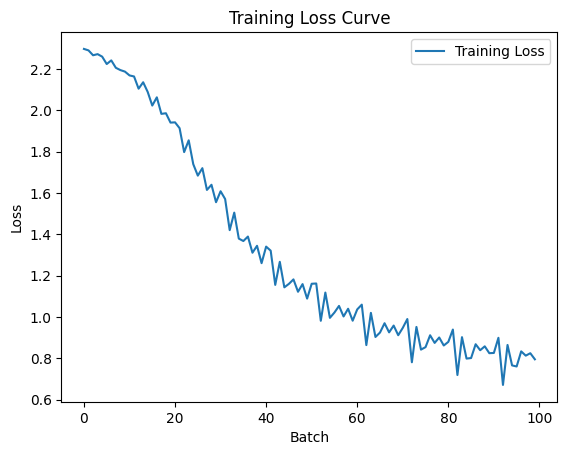

In [27]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#Train and test the model
train_losses = []
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")
plot_loss_curve(train_losses)

### Answer 1.3

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loass curve for each experiment:

|Lr|Accuracy|Epoch|
|---|:---:|:---:|
|1   |Can't reach 85% | NA  |
|0.1|  85.4%  |  4  |
|0.01|     85.0%    |  17  |
|0.001  |  83.1%  | 60   |

#### Preprocessing

In [39]:
## Data Preprocessing
import numpy as np # This is for mathematical operations

# this is used in plotting
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset.
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt



batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)




Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


#### Number of epochs to get 85% Accuracy when lr = 1e-3

In [29]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#Train and test the model
train_losses = []
epochs = 60
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301378  [    0/60000]
loss: 2.292451  [ 6400/60000]
loss: 2.270141  [12800/60000]
loss: 2.269095  [19200/60000]
loss: 2.255823  [25600/60000]
loss: 2.232016  [32000/60000]
loss: 2.240329  [38400/60000]
loss: 2.209606  [44800/60000]
loss: 2.213889  [51200/60000]
loss: 2.182742  [57600/60000]
Test Error: 
 Accuracy: 41.0%, Avg loss: 2.177019 

Epoch 2
-------------------------------
loss: 2.179710  [    0/60000]
loss: 2.177180  [ 6400/60000]
loss: 2.120133  [12800/60000]
loss: 2.139746  [19200/60000]
loss: 2.092000  [25600/60000]
loss: 2.044298  [32000/60000]
loss: 2.073336  [38400/60000]
loss: 1.998491  [44800/60000]
loss: 2.012341  [51200/60000]
loss: 1.946742  [57600/60000]
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.938605 

Epoch 3
-------------------------------
loss: 1.957127  [    0/60000]
loss: 1.941205  [ 6400/60000]
loss: 1.824446  [12800/60000]
loss: 1.868296  [19200/60000]
loss: 1.752866  [25600/60000]
loss: 1.710324  [32000/600

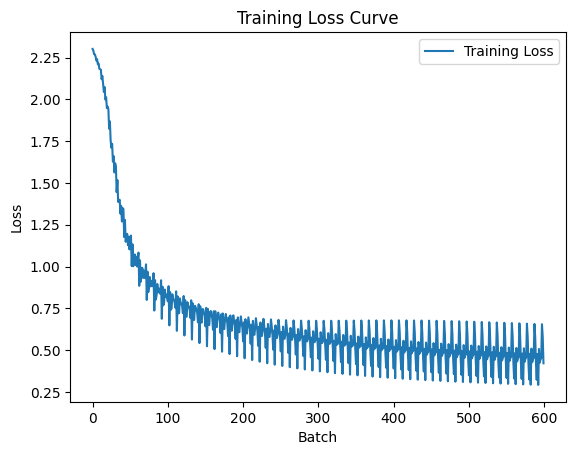

In [30]:
plot_loss_curve(train_losses)

#### Number of epochs to get 85% Accuracy when lr = 1e-2

In [32]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
#Train and test the model
train_losses = []
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311475  [    0/60000]
loss: 2.155697  [ 6400/60000]
loss: 1.792473  [12800/60000]
loss: 1.502973  [19200/60000]
loss: 1.153343  [25600/60000]
loss: 1.050452  [32000/60000]
loss: 1.002981  [38400/60000]
loss: 0.869934  [44800/60000]
loss: 0.860165  [51200/60000]
loss: 0.825155  [57600/60000]
Test Error: 
 Accuracy: 71.0%, Avg loss: 0.794588 

Epoch 2
-------------------------------
loss: 0.809178  [    0/60000]
loss: 0.852504  [ 6400/60000]
loss: 0.587967  [12800/60000]
loss: 0.783355  [19200/60000]
loss: 0.675923  [25600/60000]
loss: 0.642485  [32000/60000]
loss: 0.716568  [38400/60000]
loss: 0.694320  [44800/60000]
loss: 0.692292  [51200/60000]
loss: 0.656228  [57600/60000]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.637464 

Epoch 3
-------------------------------
loss: 0.577718  [    0/60000]
loss: 0.661791  [ 6400/60000]
loss: 0.436956  [12800/60000]
loss: 0.661939  [19200/60000]
loss: 0.594342  [25600/60000]
loss: 0.566690  [32000/600

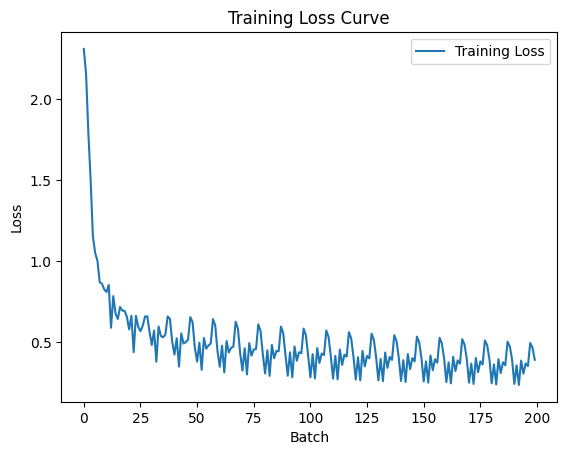

In [33]:
plot_loss_curve(train_losses)

#### Number of epochs to get 85% Accuracy when lr = 1

In [ ]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
#Train and test the model
train_losses = []
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306286  [    0/60000]
loss: 2.310283  [ 6400/60000]
loss: 2.313161  [12800/60000]
loss: 2.187906  [19200/60000]
loss: 2.437512  [25600/60000]
loss: 2.310711  [32000/60000]
loss: 2.305786  [38400/60000]
loss: 2.288608  [44800/60000]
loss: 2.300432  [51200/60000]
loss: 2.079770  [57600/60000]
Test Error: 
 Accuracy: 24.1%, Avg loss: 1.930031 

Epoch 2
-------------------------------
loss: 1.936008  [    0/60000]
loss: 2.063107  [ 6400/60000]
loss: 1.906376  [12800/60000]
loss: 1.737915  [19200/60000]
loss: 1.729809  [25600/60000]
loss: 1.725615  [32000/60000]
loss: 1.681684  [38400/60000]
loss: 1.713092  [44800/60000]
loss: 1.653746  [51200/60000]
loss: 1.659255  [57600/60000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.725897 

Epoch 3
-------------------------------
loss: 1.708390  [    0/60000]
loss: 1.711858  [ 6400/60000]
loss: 1.873954  [12800/60000]
loss: 1.838105  [19200/60000]
loss: 1.676894  [25600/60000]
loss: 1.749992  [32000/600

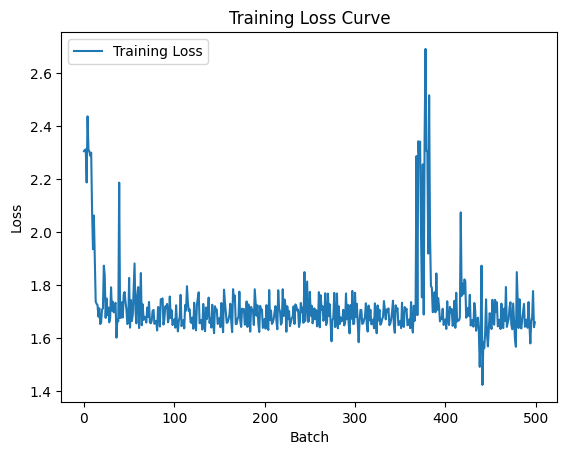

In [ ]:
plot_loss_curve(train_losses)

#### Number of epochs to get 85% Accuracy when lr = 0.1

From the results of Answer 1.2, the accuracy of the model reached 85.4% in 4 epochs only when the learning rate was 0.1

### Answer 1.4

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?

Table 1: Training Results for Different Learning Rates

* When the learning rate is too high (Lr = 1), the accuracy is very low (19.9%). This suggests that the training process diverged or was highly unstable. A high learning rate can cause the model to overshoot the optimal weights and fail to converge.
* As the learning rate is reduced, the accuracy improves. A learning rate of 0.1 achieved a relatively high accuracy of 87.5%, which indicates that the learning rate is in a reasonable range for convergence.
* Further decreasing the learning rate (0.01 and 0.001) leads to decreasing accuracy. This suggests that the learning rate is becoming too small for effective convergence, causing the training process to slow down and delayed convergence

Table 2: Epochs to Reach 85% Accuracy

* With a learning rate of 1, the model reaches only 19.9% accuracy after 50 epochs. This indicates that the high learning rate leads to overshooting of the model and the learning rate is hovering around 19 to 25%. It suggests that the model will not converge despite of any number of epochs.

* A learning rate of 0.1 achieves 85.4% accuracy after just 4 epochs. This suggests that this learning rate is efficient and helps the model quickly converge to a good solution.

* A learning rate of 0.01 achieves 85.0% accuracy after 17 epochs. It takes longer to converge compared to a learning rate of 0.1 due to small steps taken in each epoch, but still reaches the desired accuracy.

* A learning rate of 0.001 achieves 83.1% accuracy after 60 epochs. The slower convergence compared to higher learning rates might be due to the learning rate being too small. It will eventually reach accuracy of 85% but will take a lot of time to reach that value. Around 100 epochs will be taken by the model to reach 85%.

Summary:
From these observations, it's evident that an appropriate learning rate is crucial for effective training. A learning rate that is too high can lead to instability and overshooting, while a learning rate that is too low can result in slow convergence. A learning rate around **0.1** seems to be performing well in both tables, leading to relatively quick and stable convergence to an accuracy of at least 85%.

### **Answer 1.5 (5 points)**

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

The table below shows the values for learning rate 0.1

|Structures|Accuracy|Parameters|
|---|:---:|:---:|
|Base   |   88.5   |669706|
|Deeper|    87.7      |830090|
|Wider|    88.2     |1863690|

The table below shows the values for learning rate 0.01

|Structures|Accuracy|Parameters|
|---|:---:|:---:|
|Base   |  85.6   |669706|
|Deeper|   85.5    |830090|
|Wider| 85.9   |1863690|

#### Base Model

In [49]:
## Data Preprocessing
import numpy as np # This is for mathematical operations

# this is used in plotting
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset.
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets.
##Every TorchVision Dataset includes two arguments:
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Number of Parameters in the base model

In [50]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 669706


In [51]:
#Train and test the model
train_losses = []
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304421  [    0/60000]
loss: 2.150870  [ 6400/60000]
loss: 1.757620  [12800/60000]
loss: 1.463001  [19200/60000]
loss: 1.123916  [25600/60000]
loss: 1.033406  [32000/60000]
loss: 1.001088  [38400/60000]
loss: 0.885351  [44800/60000]
loss: 0.868201  [51200/60000]
loss: 0.807125  [57600/60000]
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.794987 

Epoch 2
-------------------------------
loss: 0.803205  [    0/60000]
loss: 0.849606  [ 6400/60000]
loss: 0.601737  [12800/60000]
loss: 0.786954  [19200/60000]
loss: 0.673427  [25600/60000]
loss: 0.646083  [32000/60000]
loss: 0.719157  [38400/60000]
loss: 0.706454  [44800/60000]
loss: 0.701604  [51200/60000]
loss: 0.629168  [57600/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.636070 

Epoch 3
-------------------------------
loss: 0.567069  [    0/60000]
loss: 0.662679  [ 6400/60000]
loss: 0.446748  [12800/60000]
loss: 0.669133  [19200/60000]
loss: 0.588234  [25600/60000]
loss: 0.564576  [32000/600

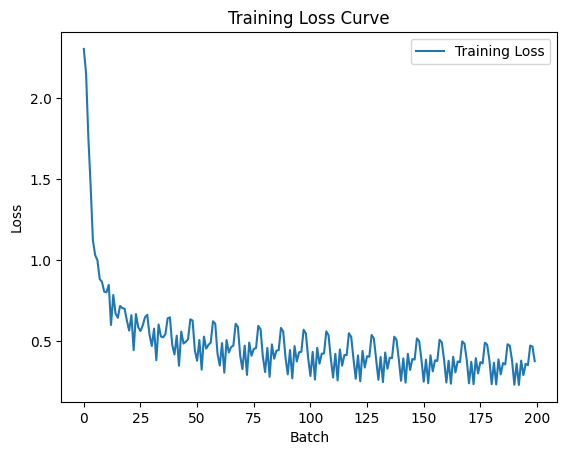

In [52]:
plot_loss_curve(train_losses)

#### Wider Network

In [53]:
## Data Preprocessing
import numpy as np # This is for mathematical operations

# this is used in plotting
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset.
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets.
##Every TorchVision Dataset includes two arguments:
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [54]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1863690


In [55]:
#Train and test the model
train_losses = []
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310171  [    0/60000]
loss: 2.122965  [ 6400/60000]
loss: 1.687782  [12800/60000]
loss: 1.404101  [19200/60000]
loss: 1.061113  [25600/60000]
loss: 0.961783  [32000/60000]
loss: 0.949786  [38400/60000]
loss: 0.830339  [44800/60000]
loss: 0.829714  [51200/60000]
loss: 0.778957  [57600/60000]
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.759860 

Epoch 2
-------------------------------
loss: 0.750994  [    0/60000]
loss: 0.808094  [ 6400/60000]
loss: 0.559475  [12800/60000]
loss: 0.760780  [19200/60000]
loss: 0.647034  [25600/60000]
loss: 0.613092  [32000/60000]
loss: 0.680673  [38400/60000]
loss: 0.670657  [44800/60000]
loss: 0.687130  [51200/60000]
loss: 0.609164  [57600/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.612210 

Epoch 3
-------------------------------
loss: 0.535103  [    0/60000]
loss: 0.618920  [ 6400/60000]
loss: 0.423749  [12800/60000]
loss: 0.643333  [19200/60000]
loss: 0.564965  [25600/60000]
loss: 0.542816  [32000/600

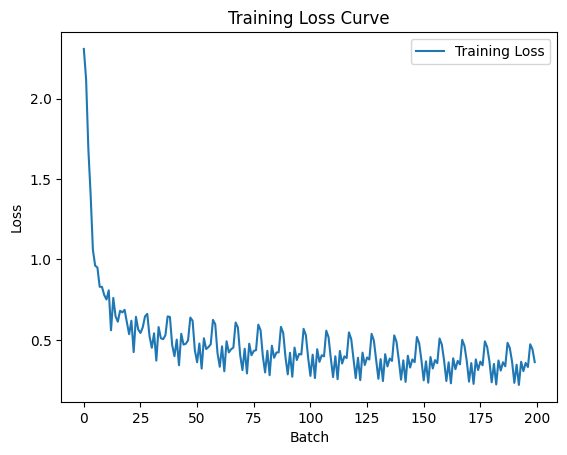

In [56]:
plot_loss_curve(train_losses)

#### Deeper Network

In [57]:
## Data Preprocessing
import numpy as np # This is for mathematical operations

# this is used in plotting
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset.
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets.
##Every TorchVision Dataset includes two arguments:
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [58]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 830090


In [59]:
#Train and test the model
train_losses = []
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301011  [    0/60000]
loss: 2.300746  [ 6400/60000]
loss: 2.296107  [12800/60000]
loss: 2.295005  [19200/60000]
loss: 2.274042  [25600/60000]
loss: 2.270375  [32000/60000]
loss: 2.259120  [38400/60000]
loss: 2.219357  [44800/60000]
loss: 2.184343  [51200/60000]
loss: 2.024717  [57600/60000]
Test Error: 
 Accuracy: 42.3%, Avg loss: 1.928167 

Epoch 2
-------------------------------
loss: 1.969398  [    0/60000]
loss: 1.647519  [ 6400/60000]
loss: 1.275357  [12800/60000]
loss: 1.223793  [19200/60000]
loss: 0.959672  [25600/60000]
loss: 0.971107  [32000/60000]
loss: 1.003260  [38400/60000]
loss: 0.897619  [44800/60000]
loss: 0.872981  [51200/60000]
loss: 0.904992  [57600/60000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 0.884180 

Epoch 3
-------------------------------
loss: 0.904833  [    0/60000]
loss: 0.910879  [ 6400/60000]
loss: 0.696329  [12800/60000]
loss: 0.840786  [19200/60000]
loss: 0.717021  [25600/60000]
loss: 0.643318  [32000/600

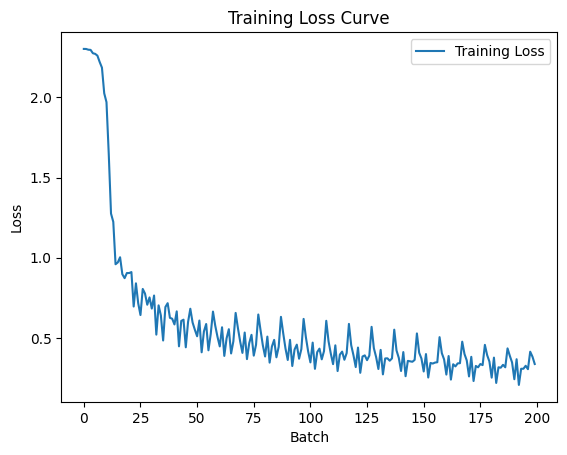

In [60]:
plot_loss_curve(train_losses)

#### Observations

A wider network refers to increasing the number of neurons or units in each layer of the neural network. Wider models can capture more complex patterns and features from the data due to the increased capacity.

A deeper model refers to increasing the number of layers in the neural network. Deeper models can learn hierarchical representations of data, extracting features at different levels of abstraction.

* In the context of these experiments, the base model seems to perform consistently well across both learning rates, indicating that it's a robust architecture for this problem.
* The deeper model doesn't show a significant improvement in accuracy compared to the base model, suggesting that increasing depth might not be highly beneficial for this specific task.
* The wider model doesn't consistently outperform the base model either, indicating that simply increasing width might not lead to substantial improvements.
* The effect of learning rate is notable, as accuracy decreases with a lower learning rate for all model structures. This suggests that finding an appropriate learning rate is crucial for effective training.

### Answer 1.6

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

Epoch 1: Train Loss = 1.3239
Epoch 2: Train Loss = 0.6930
Epoch 3: Train Loss = 0.5770
Epoch 4: Train Loss = 0.5198
Epoch 5: Train Loss = 0.4880
Epoch 6: Train Loss = 0.4669
Epoch 7: Train Loss = 0.4511
Epoch 8: Train Loss = 0.4383
Epoch 9: Train Loss = 0.4274
Epoch 10: Train Loss = 0.4180


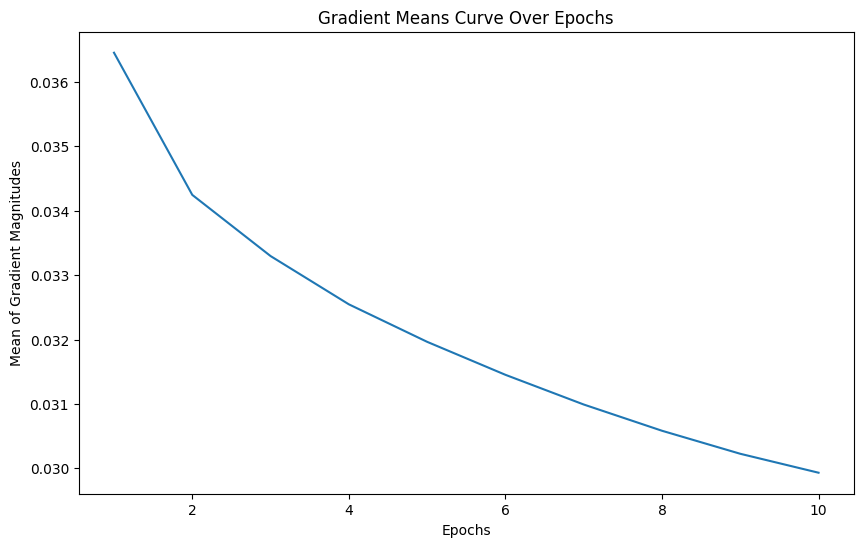

In [69]:
# Initialize the model and optimizer
model = NeuralNetwork()
optimizer =torch.optim.SGD(model.parameters(), lr=0.01)

# Initialize lists to store gradient means
gradient_means = []

# Training loop with gradient calculations
for epoch in range(10):
    model.train()
    running_loss = 0.0
    total_gradients = 0

    for batch, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Calculate the mean of gradients and store
        total_gradients += sum(p.grad.abs().mean() for p in model.parameters()).item()

        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    gradient_means.append(total_gradients / len(train_dataloader))
    print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}")

# Plot the gradient means curve for the first 100 training steps
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(gradient_means)+1), gradient_means)
plt.xlabel("Epochs")
plt.ylabel("Mean of Gradient Magnitudes")
plt.title("Gradient Means Curve Over Epochs")
plt.show()


### **Answer 1.7 (5 points)**

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with regard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [ ]:
## Data Preprocessing
import numpy as np # This is for mathematical operations

# this is used in plotting
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset.
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets.
##Every TorchVision Dataset includes two arguments:
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_stack = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)
        x = self.fc_stack(x)
        return x


model = ConvolutionalNeuralNetwork().to(device)
print(model)

###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
Using cuda device
ConvolutionalNeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_stack): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
#Train and test the model
train_losses = []
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295689  [    0/60000]
loss: 0.905884  [ 6400/60000]
loss: 0.574250  [12800/60000]
loss: 0.649919  [19200/60000]
loss: 0.593959  [25600/60000]
loss: 0.520902  [32000/60000]
loss: 0.405904  [38400/60000]
loss: 0.524093  [44800/60000]
loss: 0.589419  [51200/60000]
loss: 0.416643  [57600/60000]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.481260 

Epoch 2
-------------------------------
loss: 0.348791  [    0/60000]
loss: 0.378825  [ 6400/60000]
loss: 0.310393  [12800/60000]
loss: 0.423431  [19200/60000]
loss: 0.391629  [25600/60000]
loss: 0.414340  [32000/60000]
loss: 0.319617  [38400/60000]
loss: 0.484717  [44800/60000]
loss: 0.500259  [51200/60000]
loss: 0.369229  [57600/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.371316 

Epoch 3
-------------------------------
loss: 0.228293  [    0/60000]
loss: 0.265300  [ 6400/60000]
loss: 0.263657  [12800/60000]
loss: 0.363347  [19200/60000]
loss: 0.312589  [25600/60000]
loss: 0.391255  [32000/600

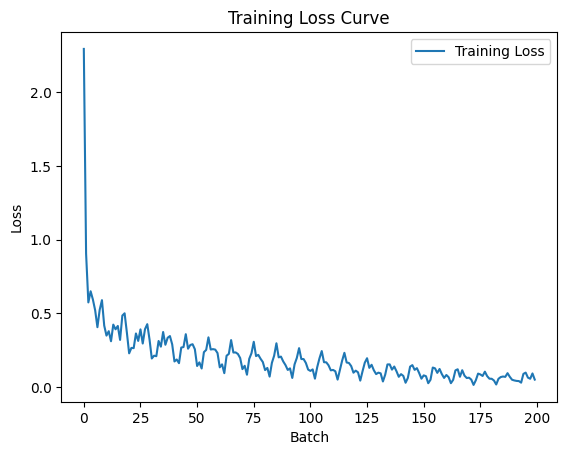

In [ ]:
plot_loss_curve(train_losses)

In [ ]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 421642


#### Comparison of previous MLP Model and CNN Model

|Model|Accuracy|Number of parameters|
|:---:|:---:|:---:|
|MLP   | 88.0% | 669,706    |
|CNN|   91.5%     |  421642  |


Observations:

  Number of Parameters:
    The CNN model has significantly fewer parameters (421,642) compared to the "Base" MLP model (669,706).
    This reduction in parameters is due to the shared weights in convolutional layers, allowing CNNs to capture local patterns with fewer parameters.

  Accuracy:
    The CNN model achieves a higher accuracy of 91.5% after 20 epochs compared to the accuracy of the "Base" MLP model which is around 88.0%.
    This improved accuracy suggests that the CNN architecture is more effective in capturing the spatial features and patterns present in the Fashion MNIST dataset.

  Convergence:
    The CNN model converges faster (reaches a higher accuracy in fewer epochs) than the "Base" MLP model took more than 20 epochs to achieve similar or lower accuracy.        
    CNNs are well-suited for image data due to their architecture's ability to capture local features and hierarchies, which can lead to quicker convergence on image classification tasks.

  Overall Performance:
    The CNN model's lower number of parameters combined with its higher accuracy and faster convergence makes it a more efficient and effective choice for image classification tasks like Fashion MNIST.

It's important to note that the specific findings can vary based on factors such as the choice of hyperparameters, learning rates, batch sizes, and model architectures. However, the general trend suggests that for image data, CNNs tend to outperform MLPs in terms of accuracy and convergence while utilizing fewer parameters.